# Task 3 - Feature Matching using SIFT

Write a function which takes an image from the same dataset for training
and testing as in the previous task.

**Main steps:**
1. You first extract keypoints and feature descriptors from your
Test and Train images using standard SIFT or SURF feature extraction
function from a library.
2. Then you match features between images which will give you the raw noisy matches (correspondences).
3. Now you should decide which geometric transform to use to reject the outliers. (use RANSAC)
4. Finally, you will
define a score on the obtained inlier matches and will use this to detect the
objects (icons) scoring high for a given Test image. A basic score is counting
the inlier matches.

**Output:**

Detect objects in the Test images using SIFT or equivalent features (such as SURF), recognize to which class they belong, and identify
their scales and orientations. Similar as Task2, for visual demonstration the
function should open a box around each detected object and indicate its class
label. This box is scaled and rotated according to the object’s scale and orientation. Demonstrate example images(s) of the outcome detection in your report. Besides, demonstrate example images(s) that shows the feature-based
matches established between the recognised objects and a Test image, before
and after the outlier refinement step.

**Evaluation:**

Evaluate your algorithm on all Test images to report the overall Intersection over Union (IoU), False Positive (FPR), True Positive (TPR) and
Accuracy (ACC) rates, as well as the average runtime. Refer to the following report http://host.robots.ox.ac.uk/pascal/VOC/voc2012/devkit_
doc.pdf section 4.4 for further information about the evaluation metrics.
Show and explain cases where this scheme finds difficulty to perform correctly. Compare the SIFT/SURF results to that of Task2 algorithm e.g.,
does it improve the overall speed or accuracy? How much? Why?

**Hyperparameter tuning:**

Similarly, you will have some hyper-parameters to tune. This includes the
number of Octaves and the (within-octave) Scalelevels within SIFT to build
scale-spaces for keypoint detection, and the MaxRatio parameter within the
matchFeatures function to reject weak matches. How are these parameters
set for this task? Show quantitatively why.

**Notes:**

For task 2 and task 3, you are allowed to use library functions for creating the pyramid or using Gaussian convolution. You are also allowed to use the library functions for extracting features, for e.g. extracting SIFT features. You are allowed to use math libraries, for instance svd functions for computing the homography.

You are *not* allowed to use the `cv2.matchTemplate` or `cv2.BFMatcher`.
- Basically functions for matching features need to be coded. 
- You would need to implement RANSAC also yourself.

## Tutorial

[Source](https://docs.opencv.org/4.9.0/d1/de0/tutorial_py_feature_homography.html)

So what we did in last session? We used a queryImage, found some feature points in it, we took another trainImage, found the features in that image too and we found the best matches among them. In short, we found locations of some parts of an object in another cluttered image. This information is sufficient to find the object exactly on the trainImage.

For that, we can use a function from calib3d module, ie cv.findHomography(). If we pass the set of points from both the images, it will find the perspective transformation of that object. Then we can use cv.perspectiveTransform() to find the object. It needs at least four correct points to find the transformation.

We have seen that there can be some possible errors while matching which may affect the result. To solve this problem, algorithm uses RANSAC or LEAST_MEDIAN (which can be decided by the flags). So good matches which provide correct estimation are called inliers and remaining are called outliers. cv.findHomography() returns a mask which specifies the inlier and outlier points.

### Imports & Constants

In [5]:
import cv2 as cv
import numpy as np

from matplotlib import pyplot as plt

VERBOSE = False

MIN_MATCH_COUNT = 10
FLANN_INDEX_KDTREE = 1

# QUERY_IMAGE_FILE = "./IconDataset/png/005-silo.png"
QUERY_IMAGE_FILE = "./IconDataset/png/001-lighthouse.png"
TRAIN_IMAGE_FILE = "./Task3Dataset/images/test_image_2.png"

### Find SIFT features & apply ratio test to find best matches

[Feature matching with FLANN](https://docs.opencv.org/3.4/d5/d6f/tutorial_feature_flann_matcher.html)

In [6]:
# Load images.
query_img = cv.imread(QUERY_IMAGE_FILE)
train_img = cv.imread(TRAIN_IMAGE_FILE)

if VERBOSE:
    plt.imshow(query_img)
    plt.show()

In [7]:
# Instantiate a SIFT detector.
sift = cv.SIFT.create()

# Determine keypoints and generate descriptors using SIFT.
kp_query, desc_query = sift.detectAndCompute(query_img, None)
kp_train, desc_train = sift.detectAndCompute(train_img, None)

This is something you will need to implement yourself. We are not allowed to use off-the-shelf feature matchers.

In [8]:
index_params = {"algorithm": FLANN_INDEX_KDTREE, "trees": 5}
search_params = {"checks": 50}

flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc_query, desc_train, k=2)

# Store all good matches as per Lowe's ratio test.
good_matches = []
for m, n in matches:
    if m.distance < 0.7*n.distance:
        good_matches.append(m)

Now, we set a condition that at least 10 matches (defiend by `MIN_MATCH_COUNT`) should be present to find the object. Otherwise, show a message saying not enough matches are present.

If enough matches are found, we extract the locations of the matched keypoints in both images. They are passed to find the perspective transform. Once we have this 3x3 transformation matrix, we use it to transform the corners of `query_img` to corresponding points in `train_image`. Then, we draw it.

In [9]:
if len(good_matches) <= MIN_MATCH_COUNT:
    print(f"Not enough matches are found - {len(good_matches)}/{MIN_MATCH_COUNT}")
    matches_mask = None
else:
    source_points = np.array([kp_query[m.queryIdx].pt for m in good_matches], dtype=np.float32).reshape(-1,1,2)
    dest_points = np.array([kp_train[m.trainIdx].pt for m in good_matches], dtype=np.float32).reshape(-1,1,2)

    # We need to implement `findHomography`, `RANSAC`.
    M, mask = cv.findHomography(source_points, dest_points, cv.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    h, w, c = query_img.shape
    points = np.array([[0,0],[0,h-1],[w-1,h-1],[w-1,0]], dtype=np.float32).reshape(-1,1,2)
    destination = cv.perspectiveTransform(points, M)

    train_img = cv.polylines(train_img, [np.int32(destination)], True, 255, 3, cv.LINE_AA)

Finally, we draw our inliers (if we successfully found the object) or matching keypoints (if we failed).

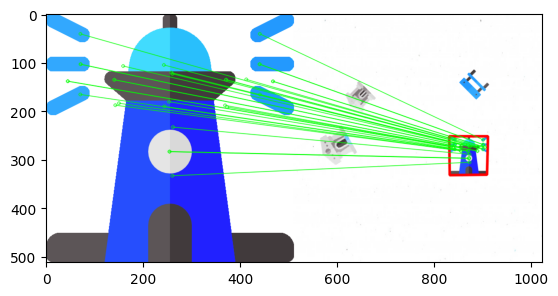

In [10]:
draw_params = {
    "matchColor": (0, 255, 0), # Draw matches in green.
    "singlePointColor": None,
    "matchesMask": matches_mask, # Only draw inliers.
    "flags": 2,
} 

matches_img = cv.drawMatches(query_img, kp_query, train_img, kp_train, good_matches, None, **draw_params)
plt.imshow(matches_img)
plt.show()

## Re-implementation

### Imports & Constants

In [1]:
import cv2 as cv
import numpy as np

from pathlib import Path
from task3 import ImageDataset, ObjectDetector

QUERY_IMAGE_DIR = Path("IconDataset", "png")
TEST_IMAGE_PATH = Path("Task3Dataset", "images", "test_image_2.png")

FLANN_INDEX_KDTREE = 1
FLANN_INDEX_PARAMS = {"algorithm": FLANN_INDEX_KDTREE, "trees": 5}
FLANN_SEARCH_PARAMS = {"checks": 50}

In [2]:
query_images = ImageDataset(QUERY_IMAGE_DIR, file_ext="png")
detector = ObjectDetector(query_images, {}, FLANN_INDEX_PARAMS, FLANN_SEARCH_PARAMS)

In [3]:
test_img = cv.imread(str(TEST_IMAGE_PATH), cv.IMREAD_UNCHANGED)

Skipping query image IconDataset/png/009-airport.png. Not enough good matches found - 8/10
Skipping query image IconDataset/png/033-hydrant.png. Not enough good matches found - 4/10
Skipping query image IconDataset/png/041-windmill.png. Not enough good matches found - 5/10
Skipping query image IconDataset/png/025-factory.png. Not enough good matches found - 10/10
Skipping query image IconDataset/png/037-post-office.png. Not enough good matches found - 9/10
Skipping query image IconDataset/png/006-church.png. Not enough good matches found - 0/10
Skipping query image IconDataset/png/040-bus-stop.png. Not enough good matches found - 5/10
Skipping query image IconDataset/png/026-shop.png. Not enough good matches found - 4/10
Skipping query image IconDataset/png/012-bus.png. Not enough good matches found - 2/10
Query image IconDataset/png/002-bike.png yields enough good matches. Finding transform...
Skipping query image IconDataset/png/028-government.png. Not enough good matches found - 4/1

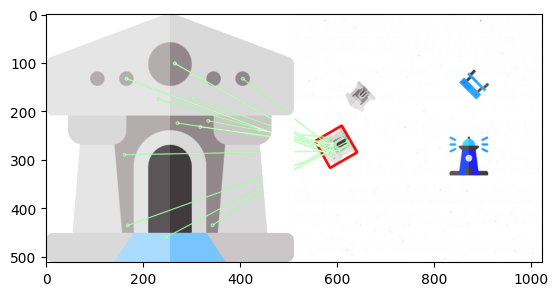

Query image IconDataset/png/007-supermarket.png yields enough good matches. Finding transform...
Query image IconDataset/png/004-bridge.png yields enough good matches. Finding transform...


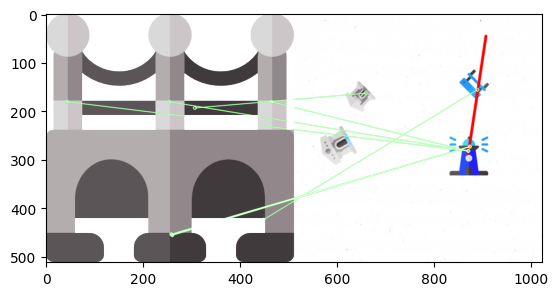

Skipping query image IconDataset/png/029-theater.png. Not enough good matches found - 4/10
Query image IconDataset/png/049-school.png yields enough good matches. Finding transform...
Query image IconDataset/png/047-restaurant.png yields enough good matches. Finding transform...
Skipping query image IconDataset/png/013-water-well.png. Not enough good matches found - 7/10
Query image IconDataset/png/011-trash.png yields enough good matches. Finding transform...
Skipping query image IconDataset/png/022-car.png. Not enough good matches found - 5/10
Skipping query image IconDataset/png/015-barn.png. Not enough good matches found - 4/10
Skipping query image IconDataset/png/048-hospital.png. Not enough good matches found - 5/10
Skipping query image IconDataset/png/024-fountain.png. Not enough good matches found - 7/10
Skipping query image IconDataset/png/035-police.png. Not enough good matches found - 9/10
Skipping query image IconDataset/png/027-gas-station.png. Not enough good matches found

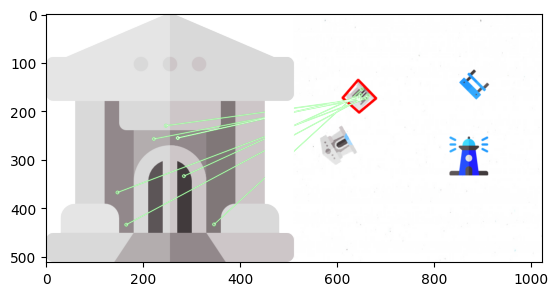

Query image IconDataset/png/003-bridge-1.png yields enough good matches. Finding transform...
Skipping query image IconDataset/png/034-billboard.png. Not enough good matches found - 4/10
Skipping query image IconDataset/png/021-solar-panel.png. Not enough good matches found - 5/10
Skipping query image IconDataset/png/016-house.png. Not enough good matches found - 6/10
Query image IconDataset/png/044-ferris-wheel.png yields enough good matches. Finding transform...
Skipping query image IconDataset/png/050-cemetery.png. Not enough good matches found - 8/10
Skipping query image IconDataset/png/030-telephone-booth.png. Not enough good matches found - 2/10
Skipping query image IconDataset/png/032-van.png. Not enough good matches found - 9/10
Skipping query image IconDataset/png/039-university.png. Not enough good matches found - 1/10
Query image IconDataset/png/042-tractor.png yields enough good matches. Finding transform...
Query image IconDataset/png/010-bench.png yields enough good match

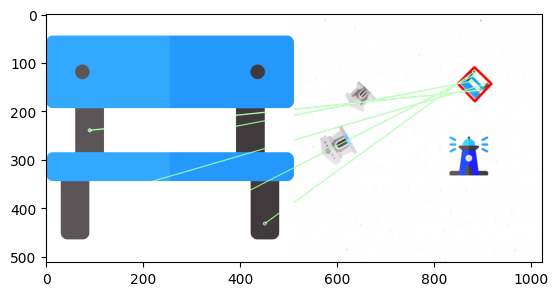

Query image IconDataset/png/001-lighthouse.png yields enough good matches. Finding transform...


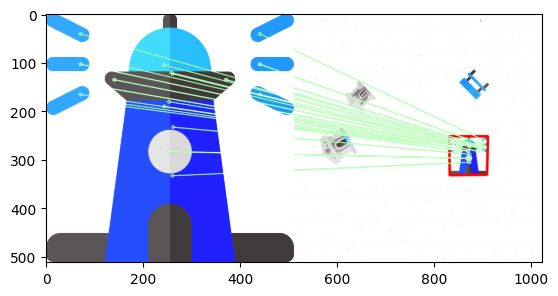

Skipping query image IconDataset/png/014-flower.png. Not enough good matches found - 9/10
Query image IconDataset/png/005-silo.png yields enough good matches. Finding transform...
Skipping query image IconDataset/png/046-fire-station.png. Not enough good matches found - 4/10
Skipping query image IconDataset/png/045-museum.png. Not enough good matches found - 5/10
Skipping query image IconDataset/png/019-prison.png. Not enough good matches found - 8/10
Skipping query image IconDataset/png/017-cinema.png. Not enough good matches found - 5/10


In [4]:
detector.detect(test_img)